
**TOV Stars with Polytropic equation of state**

N. Stergioulas

Aristotle University of Thessaloniki

v1.0 (May 2018)


##### Content provided under a Creative Commons Attribution license, [CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/); code under [MIT License](https://opensource.org/licenses/MIT). (c)2018 [Nikolaos Stergioulas](http://www.astro.auth.gr/~niksterg/)

In [1]:
from __future__ import print_function, division
import numpy as np
from scipy import fftpack 
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sp
from scipy import integrate
from scipy import optimize
from scipy.interpolate import PchipInterpolator
from scipy.interpolate import lagrange
import sys
from decimal import Decimal
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# The TOV equations for spherical stars

Consider the metric for a spherically symmetric, stationary and asymptotic spacetime in Schwarzshild coordinates $t, r, \theta, \phi$
$$ ds^2 = -e^{\nu}dt^2 +e^{\lambda}dr^2 + r^2(d\theta^2+\sin^2\theta d\phi^2)$$
The TOV system in units $c=G=1$ is
$$ P = P(\epsilon),$$
$$ \frac{dP}{dr} = -\frac{(\epsilon+P)(m+4\pi r^3P)}{r(r-2m)},$$
$$ \frac{dm}{dr} = 4\pi r^2 \epsilon$$
$$ \frac{d\nu}{dr} = -\frac{2}{\epsilon+P}\frac{dP}{dr}=\frac{2(m+4\pi r^3P)}{r(r-2m)},$$
$$ \lambda = -\ln\left(1-\frac{2m}{r}\right),$$
The central values are
$$ P(0) = P_c,$$
$$ m(0) = 0,$$
$$ \nu(0) = -1.$$
where the last choice is arbitrary (after the interior solution is obtained, $\nu$ will be shifted to match the Schwarzschild exterior solution at the surface).

Near the center, we do a series expansion 
$$P(r) \simeq P_c -(2\pi)(\epsilon_c+P_c) \left( P_c+\frac{1}{3}\epsilon_c \right) r^2 + O(r^4),$$
$$ m(r) \simeq \frac{4}{3}\pi\epsilon_cr^3 + O(r^4),$$
$$ \nu(r) \simeq \nu_c + 4\pi \left(P_c+ \frac{1}{3}\epsilon_c \right)r^2 + O(r^4).$$
The value of $\nu$ at the surface is 
$$ \nu_\star = -\lambda_\star = \ln\left(1-\frac{2M}{R}\right).$$
The gravitational mass can be obtained as 
$$ M = \int_0^R 4\pi r^2\epsilon dr,$$
or as
$$ M = \int_0^R 4\pi r^2 e^{(\nu+\lambda)/2}(\epsilon +3P)dr,$$
The baryon mass of the star is
$$ M_0 = \int_0^R 4\pi r^2 e^{\lambda/2}\rho dr. $$
The polytropic equation of state is
$$P = K\rho^\Gamma,$$
$$ \epsilon = \rho + \frac{P}{\Gamma-1}$$


In the numerical implementation, we use a length scale of $M_\odot =1$. For the output, units are also converted to CGS.

# Numerical implementation

Define the system $ f(r, {\mathbf y} (r))$ of differential equations to be solved:
$$ f(r, {\mathbf y} (r)) = \frac{d}{dr} \begin{bmatrix} y_0(r)\\ y_1(r) \\ y_2(r) \end{bmatrix}
  = \frac{d}{dr} \begin{bmatrix} P(r)\\ m(r) \\ \nu(r) \end{bmatrix} = 
  \begin{bmatrix} -\frac{(\epsilon+P)(m+4\pi r^3P)}{r(r-2m)} \\  
                  4\pi r^2 \epsilon \\
                  \frac{2(m+4\pi r^3P)}{r(r-2m)} 
                  \end{bmatrix}$$

In [2]:
def f(r, y, args):
    Gamma, K = args
    eps = pow(y[0]/K, 1.0/Gamma) +y[0]/(Gamma-1)   # required below
    
    return [ -( eps + y[0] )*( y[1] + 4.0*np.pi*pow(r,3.0)*y[0] )/( r*(r-2.0*y[1]) ), 
            
             4*np.pi*pow(r,2.0)*eps,
            
             2.0*( y[1] + 4.0*np.pi*pow(r,3.0)*y[0] )/( r*(r-2.0*y[1]) ) 
           ]

Set polytropic index and constant:

In [3]:
Gamma = 2.0
K = 100.0
args = (Gamma, K)

def P_of_eps(x):    # define P(epsilon)
    return ( x-K*pow(eps_c-x/(Gamma-1.0),Gamma) )


Set the central values $\epsilon_c$ and $\nu_c$ and the starting values for the system of ODEs:

In [4]:

# choose the central energy density and find the central pressure
eps_c = 1.444e-3
P_c_approx = K*pow(eps_c, Gamma) # approx. value for setting bounds in root finding
P_c = optimize.brentq( P_of_eps, 0.5*P_c_approx, 10*P_c_approx, xtol=1e-16 )

# set an arbitrary starting value for nu at the center
nu_c = -1.0

# set a safe max r, based on 4x radius of 1 Msun uniform density Newt. model
r_max = 4.0 * pow( 3.0/(4.0*np.pi*eps_c), 1.0/3.0)

# create an equidistant array of values for r
N = 25601
r = np.linspace(0.0, r_max, N)
dr = r[1] - r[0]

# compute P, m, nu at r=dr by Taylor expansion
P_1 =  P_c - (2.0*np.pi)*(eps_c+P_c)*(P_c+(1.0/3.0)*eps_c)*pow(dr,2.0)
m_1 =  (4.0/3.0)*np.pi*eps_c*pow(dr, 3.0)
nu_1 = nu_c + 4.0*np.pi*(P_c+(1.0/3.0)*eps_c)*pow(dr,2.0)

# set starting values at r=dr for numerical integration
y0 = [P_1, m_1, nu_1]


Define an instant of the numerical solution of the ODE system

In [5]:

solve = integrate.ode(f)
solve.set_integrator('lsoda', rtol=1e-12, atol=1e-50,ixpr=True);
solve.set_initial_value(y0, dr);
solve.set_f_params(args);


Integrate from starting point to the surface (where $P=0$):

In [6]:
# create the solution vector
y = np.zeros((len(r), len(y0)))

# fill the solution vector with the values at the center
y[0,:] = [P_c, 0.0, nu_c]

# initialize counter
idx = 1

# integrate repeatedly to next grid point until P becomes zero
while solve.successful() and solve.t < r[-1] and solve.y[0]>0.0:
    
      y[idx, :] = solve.y
      solve.integrate(solve.t + dr)
      idx += 1

# last grid point with positive pressure
idxlast = idx-1 

# radius at last positive pressure grid point
R_last = r[idxlast]

# mass at last positive pressure grid point
Mass_last = y[idxlast][1]


Locate real radius by finding the location where h=1.0.

In [7]:
# use last 4 points to construct interpolant
r_data = np.zeros(4)
h_data = np.zeros(4)
eps_data = np.zeros(4)
rho_data = np.zeros(4)
P_data = np.zeros(4)
dmdr_data = np.zeros(4)

for i in range(idxlast-3,idxlast+1):
    r_data[i-idxlast+3] = r[i]
    eps_data[i-idxlast+3] = pow(y[i][0]/K, 1.0/Gamma) + y[i][0]/(Gamma-1)
    rho_data[i-idxlast+3] = pow(y[i][0]/K, 1.0/Gamma)
    P_data[i-idxlast+3] = y[i][0]
    h_data[i-idxlast+3] = (eps_data[i-idxlast+3] + P_data[i-idxlast+3]) \
                           / rho_data[i-idxlast+3] -1.0
    dmdr_data[i-idxlast+3] = 4.0*np.pi*r[i]**2*eps_data[i-idxlast+3]

h_interp = PchipInterpolator(r_data, h_data)

# find the root using Brent's method
Radius = optimize.brentq( h_interp, r_data[0], r_data[3]+3*dr, xtol=1e-16 )

display(Radius)

9.585429276495795

Locate radius more accurately (to 4th-order) using a cubic Hermite interpolant of the specific enthalpy h-1.

In [8]:
def hHerm (r):
    r_last_1 = R_last-dr
    r_last = R_last
    w = (r-r_data[2])/dr
    m_last_1 = y[idxlast-1][1]
    m_last = y[idxlast][1]
    dhdr_last_1 = - (h_data[2]+1.0)*(m_last_1 + \
                            4.0*np.pi*r_last_1**3*y[idxlast-1][0])/ \
                           (r_last_1*(r_last_1-2.0*m_last_1))
    dhdr_last = - (h_data[3]+1.0)*(m_last + \
                           4.0*np.pi*r_last**3*y[idxlast][0])/ \
                           (r_last*(r_last-2.0*m_last))
    return (h_data[2]+1.0)*(2.0*pow(w,3.0)-3.0*pow(w,2.0)+1.0)+ \
                          (h_data[3]+1.0)*(2.0*pow(1.0-w,3.0)-3.0*pow(1.0-w,2.0)+1.0) \
                          + ( dhdr_last_1*(pow(w,3.0)-2.0*pow(w,2.0)+w) - \
                           dhdr_last*(pow(1-w,3.0)-2.0*pow(1-w,2.0)+1-w))*dr -1.0

In [9]:
Radius = optimize.brentq( hHerm, r_data[0], r_data[3]+3*dr, xtol=1e-16 )
display(Radius)

9.585429276491004

Correct mass by adding last missing trapezoid:

In [10]:
Mass = Mass_last + 0.5*4*np.pi*R_last**2*eps_data[3]*(Radius-R_last)
display(Mass)

1.4002084369045944

In [11]:
dmdr_interp_pchip = PchipInterpolator(r_data, dmdr_data)
dmdr_midpoint = dmdr_interp_pchip((R_last+Radius)/2)
Dmass_simps = (1.0/3.0)*(Radius-R_last)/2*(dmdr_interp_pchip(R_last)+4.0*dmdr_midpoint+dmdr_interp_pchip(Radius))

Mass = Mass_last + Dmass_simps

display(Mass)

1.4002084369046766

Construct table with main solution variables:

In [12]:
values = np.zeros((idxlast+1, 9)) 

for i in range(0,idxlast+1): 
    values[i][0] = r[i]
    values[i][1] = pow(y[i][0]/K, 1.0/Gamma)  # rho
    values[i][2] = pow(y[i][0]/K, 1.0/Gamma) + y[i][0]/(Gamma-1)  # epsilon
    values[i][3] = y[i][0]   # P
    values[i][4] = y[i][1]   # m
    values[i][5] = y[i][2]   # nu (arbitrary)

# lambda
values[0][6] = 0.0
for i in range(1,idxlast+1):     
    values[i][6] = - np.log(1.0-2.0*y[i][1]/r[i])
    
values[:, 7] = (values[:, 2] + values[:, 3])/values[:, 1]  # h
values[:, 8] = np.gradient(values[:, 3],dr,edge_order=2)/(values[:,2] +values[:,3] )  
                                                                # (e+P)^{-1} dP/dr

Match $\nu$ at the surface, using Schwarzshild vacuum solution:

In [13]:
# arbitrary nu at the surface
nu_s_old = y[idxlast][2]

# correct nu at the surface
nu_s = np.log(1.0-2.0*Mass/Radius)

# shift nu inside star by difference
values[:, 5] = values[:, 5] + (-nu_s_old + nu_s)

Compute baryon mass and alternative expression for gravitational mass:

In [14]:
# construct radius array and integrands for baryon and alternative mass integration

rint = np.zeros(idxlast+1)
m0int = np.zeros(idxlast+1)
mint_alt = np.zeros(idxlast+1)

# fill radius array and integrands 

for i in range(0,idxlast+1): 
    rint[i] = values[i][0]
    m0int[i] = 4.0*np.pi*pow(rint[i],2.0)*np.exp(values[i][6]/2.0)*values[i][1]
    mint_alt[i] = 4.0*np.pi*pow(rint[i],2.0)*np.exp((values[i][5]+values[i][6])/2.0) \
                  *(values[i][2]+3.0*values[i][3])

# integrate using Simpson's method
M0_last = integrate.simps( m0int, dx=dr)
M_alt_last = integrate.simps( mint_alt, dx=dr, even='last')

# correct M0 and M_alt by adding last trapezoid
M0 = M0_last + 0.5*4.0*np.pi*R_last**2*np.exp(values[idxlast][6]/2.0) \
                      *values[idxlast][1]*(Radius-R_last)

M_alt = M_alt_last + 0.5*4.0*np.pi*R_last**2* np.exp((values[idxlast][5]
                            +values[idxlast][6])/2.0)*(values[idxlast][2] \
                                +3.0*values[idxlast][3]) *(Radius-R_last)

# compute relative difference between mass and alt. mass
M_reldiff = (Mass-M_alt)/Mass


# Main results

In [15]:
N_gridpoints = idxlast+1

print('Number of grid points =', N_gridpoints)
print('Gamma =', Gamma)
print('K =', K)
print('rho_c =', pow(P_c/K,1/Gamma))
print('epsilon_c =', eps_c)
print('P_c =', P_c)
print('dr =', dr)
print('Radius of last grid point =', R_last)
print('Extrapolated Radius at zero pressure =', '%.16f'% Radius)
print('Baryon Mass =', M0)
print('Gravitational Mass =', '%.16f'% Mass)
print('Alternative Mass =', M_alt)
print('Rel. diff. in Mass =', M_reldiff)

Number of grid points = 11178
Gamma = 2.0
K = 100.0
rho_c = 0.0012801273872430391
epsilon_c = 0.001444
P_c = 0.000163872612756969
dr = 0.000857567061677
Radius of last grid point = 9.58502704837
Extrapolated Radius at zero pressure = 9.5854292764910038
Baryon Mass = 1.50623413665
Gravitational Mass = 1.4002084369046766
Alternative Mass = 1.40022056296
Rel. diff. in Mass = -8.66017700379e-06


# Figures

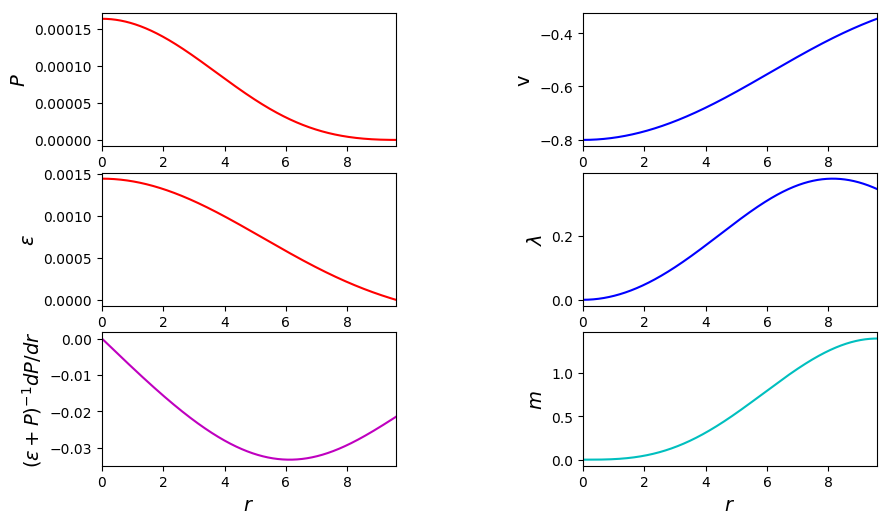

In [16]:
fig = plt.figure(figsize=(10, 6))
ax1 = plt.subplot2grid((3, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((3, 5), (1, 0), colspan=2)
ax3 = plt.subplot2grid((3, 5), (2, 0), colspan=2)
ax4 = plt.subplot2grid((3, 5), (0, 3), colspan=2)
ax5 = plt.subplot2grid((3, 5), (1, 3), colspan=2)
ax6 = plt.subplot2grid((3, 5), (2, 3), colspan=2)

ax1.plot(values[:, 0], values[:, 3], 'r')
ax1.set_ylabel('$P$', fontsize=14)
ax1.set_xlim((0,R_last))

ax2.plot(values[:, 0], values[:, 2], 'r')
ax2.set_ylabel('$\epsilon$', fontsize=14)
ax2.set_xlim((0, R_last));

ax3.plot(values[:, 0], values[:, 8], 'm')
ax3.set_xlabel('$r$', fontsize=14)
ax3.set_ylabel('$(\epsilon+P)^{-1}dP/dr$', fontsize=14)
ax3.set_xlim((0, R_last));

ax4.plot(values[:, 0], values[:, 5], 'b')
ax4.set_ylabel('v', fontsize=14)
ax4.set_xlim((0, R_last))

ax5.plot(values[:, 0], values[:, 6], 'b')
ax5.set_ylabel('$\lambda$', fontsize=14)
ax5.set_xlim((0, R_last));

ax6.plot(values[:, 0], values[:, 4], 'c')
ax6.set_ylabel('$m$', fontsize=14)
ax6.set_xlim((0, R_last));
ax6.set_xlabel('$r$', fontsize=14)

plt.show()

# Convert to CGS

In [17]:
c=2.9979e10
G=6.67408e-8
Msun=1.989e33
Length = G*Msun/c**2
Time = Length/c
Density = Msun/Length**3
dr_CGS = dr*Length
K_CGS = K * c**2 * pow(Length**3/Msun, Gamma-1)
print('Number of grid points =', N_gridpoints)
print('Gamma =', Gamma)
print('K =', K_CGS)
print('rho_c =', pow(P_c/K,1/Gamma)*Density)
print('epsilon_c/c^2 =', eps_c*Density)
print('epsilon_c =', eps_c*Density*c**2)
print('P_c =', P_c*Density*c**2)
print('dr =', dr_CGS)
print('Radius of last grid point =', R_last*Length)
print('Extrapolated Radius at zero pressure =', Radius*Length)
print('Baryon Mass =', M0*Msun)
print('Gravitational Mass =', Mass*Msun)
print('Alternative Mass =', M_alt*Msun)
print('Rel. diff. in Mass =', M_reldiff)

Number of grid points = 11178
Gamma = 2.0
K = 145604.64238088496
rho_c = 790154924825408.5
epsilon_c/c^2 = 891304820768800.5
epsilon_c = 8.010516876831778e+35
P_c = 9.090750208727276e+34
dr = 126.665983278
Radius of last grid point = 1415745.6951
Extrapolated Radius at zero pressure = 1415805.1057502609
Baryon Mass = 2.9958996978e+33
Gravitational Mass = 2.785014581e+33
Alternative Mass = 2.78503869972e+33
Rel. diff. in Mass = -8.66017700379e-06


In [18]:
values_CGS = np.zeros((idxlast+1, 9)) 

values_CGS[:, 0] = values[:, 0] * Length
values_CGS[:, 1] = values[:, 1] * Density  # rho
values_CGS[:, 2] = values[:, 2] * Density*c**2  # epsilon
values_CGS[:, 3] = values[:, 3] * Density*c**2  # P
values_CGS[:, 4] = values[:, 4] * Msun  # m
values_CGS[:, 5] = values[:, 5]         # nu
values_CGS[:, 6] = values[:, 6]         # lambda
values_CGS[:, 7] = values[:, 7] * c**2  # h
values_CGS[:, 8] = values[:, 8] / Length   # (epsilon+P)^{-1} dP/dr

# Write output files

In [19]:
np.savetxt('TOV_output.dat', values)
np.savetxt('TOV_output_CGS.dat', values_CGS)

# Convergence study

Using 11 different grid size (doubling the number of points each time), one can show the 4th-order convergence of the code to machine accuracy. Notice that the order of covergence is basically set by the taylor expansion at the center, since the Runge-Kutta integration that follows up to the surface is a highly-accurate, adaptive step-size method. The mass contained between the last grid point with positive pressure and the true radius where the pressure vanishes is added by a trapezoidal rule, but this does not influence the order of convergence (but using the cubic Hermite interpolation to locate the true radius is critical for maintaining an overall 4th-order of convergence). 

In [20]:
#different number of grid points used
Npoints = (51, 101, 201, 401, 801, 1601,  3201, 6401, 12801, 25601, 51201) 

#corresponding radii
Rpoints = (9.5856078811896612, 9.5854362495120196, 9.5854295071567517, 
           9.5854293025063289, 9.5854292773890855, 9.5854292765629605, 
           9.5854292764823121, 9.5854292764841311, 9.5854292764900038, 
           9.5854292764910038, 9.5854292764934073)

#corresponding masses
Mpoints = (1.4001068618325290, 1.4002041973306332, 1.4002083439839288, 
           1.4002084210000705, 1.4002084365940546, 1.4002084368655729, 
           1.4002084369184078, 1.4002084369019683, 1.4002084369033669, 
           1.4002084369046766, 1.4002084369042820)


In [21]:
Nconv = 10
Ndiffpoints = np.zeros(Nconv)
Mdiffpoints = np.zeros(Nconv)
Rdiffpoints = np.zeros(Nconv)
Mdiffpoints_abs = np.zeros(Nconv)
Rdiffpoints_abs = np.zeros(Nconv)

for i in range(0,Nconv):
    Ndiffpoints[i] = Npoints[i]
    Mdiffpoints[i] = (Mpoints[Nconv]-Mpoints[i])/Mpoints[Nconv]
    Rdiffpoints[i] = (Rpoints[Nconv]-Rpoints[i])/Rpoints[Nconv]
    Mdiffpoints_abs[i] = np.abs(Mpoints[Nconv]-Mpoints[i])/Mpoints[Nconv]
    Rdiffpoints_abs[i] = np.abs(Rpoints[Nconv]-Rpoints[i])/Rpoints[Nconv]


In [22]:
display(Rdiffpoints)
display(Mdiffpoints)

array([ -1.86329366e-05,  -7.27460233e-07,  -2.40639556e-08,
        -2.71379829e-09,  -9.34416365e-11,  -7.25614368e-12,
         1.15749900e-12,   9.67732915e-13,   3.55070139e-13,
         2.50735855e-13])

array([  7.25428223e-05,   3.02781610e-06,   6.63618007e-08,
         1.13584600e-08,   2.21558013e-10,   2.76451955e-11,
        -1.00883635e-11,   1.65240026e-12,   6.53506859e-13,
        -2.81796090e-13])

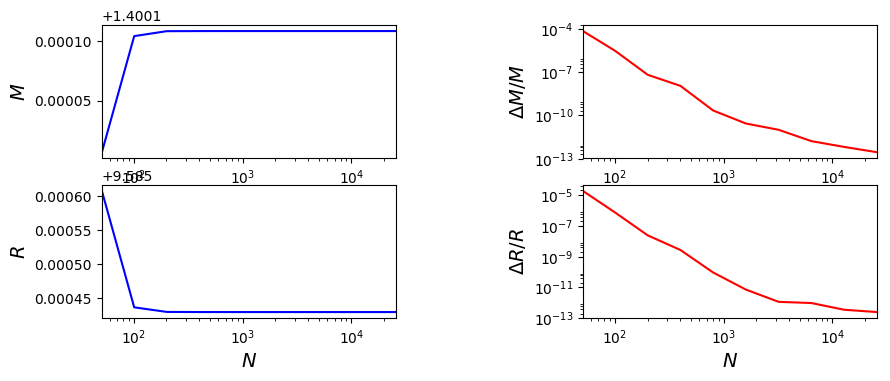

In [23]:
fig = plt.figure(figsize=(10, 6))
ax1 = plt.subplot2grid((3, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((3, 5), (1, 0), colspan=2)
ax3 = plt.subplot2grid((3, 5), (0, 3), colspan=2)
ax4 = plt.subplot2grid((3, 5), (1, 3), colspan=2)

ax1.plot(Npoints, Mpoints, 'b')
ax1.set_xscale("log")
ax1.set_ylabel('$M$', fontsize=14)
ax1.set_xlim((0,Npoints[Nconv-1]))

ax2.plot(Npoints, Rpoints, 'b')
ax2.set_xscale("log")
ax2.set_ylabel('$R$', fontsize=14)
ax2.set_xlim((0,Npoints[Nconv-1]))
ax2.set_xlabel('$N$', fontsize=14)

ax3.plot(Ndiffpoints, Mdiffpoints_abs, 'r')
ax3.set_xscale("log")
ax3.set_yscale("log")
ax3.set_ylabel('$\Delta M / M$', fontsize=14)
ax3.set_xlim((0,Npoints[Nconv-1]))

ax4.plot(Ndiffpoints, Rdiffpoints_abs, 'r')
ax4.set_xscale("log")
ax4.set_yscale("log")
ax4.set_ylabel('$\Delta R / R$', fontsize=14)
ax4.set_xlim((0,Npoints[Nconv-1]))
ax4.set_xlabel('$N$', fontsize=14)

plt.show()

Average convergence order:

In [24]:
( np.log10(Mdiffpoints_abs[5])-np.log10(Mdiffpoints_abs[0]))/( np.log10(Ndiffpoints[5])
                                                      - np.log10(Ndiffpoints[0]))

-4.2884046348423377

In [25]:
( np.log10(Rdiffpoints_abs[5])-np.log10(Rdiffpoints_abs[0]))/( np.log10(Ndiffpoints[5])
                                                      - np.log10(Ndiffpoints[0]))

-4.282125094503952

In [26]:
np.log2( (Mpoints[1]- Mpoints[0] )/( Mpoints[2] - Mpoints[1]))

4.552946716872813

In [27]:
np.log2( (Rpoints[1]- Rpoints[0] )/( Rpoints[2] - Rpoints[1]))

4.6699193941600026